In [1]:
from google.colab import drive

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, Precision
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir("drive/My Drive/")
os.getcwd()

'/content/drive/My Drive'

In [4]:
training_raw = pd.read_csv("B. RFMiD_Challenge_Dataset/2. Groundtruths/a. RFMiD_Training_Labels.csv")
print(training_raw.shape)
training_raw.head(10)

(1920, 30)


,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
training = training_raw.copy()
training.rename(columns = {"Disease_Risk": "Healthy"}, inplace = True)
training["Healthy"] = training_raw["Disease_Risk"].apply(lambda x: 1*(x==0))
training["ID"] = training_raw["ID"].astype(str) + ".png"
training.head(10)

,ID,Healthy,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.png,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.png,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6.png,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.png,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8.png,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,10.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
validation_raw = pd.read_csv("B. RFMiD_Challenge_Dataset/2. Groundtruths/b. RFMiD_Validation_Labels.csv")
print(validation_raw.shape)
validation = validation_raw.copy()
validation.rename(columns = {"Disease_Risk": "Healthy"}, inplace = True)
validation["Healthy"] = validation_raw["Disease_Risk"].apply(lambda x: 1*(x==0))
validation["ID"] = validation_raw["ID"].astype(str) + ".png"
validation.head(10)

(640, 30)


,ID,Healthy,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1.png,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
testing_raw = pd.read_csv("B. RFMiD_Challenge_Dataset/2. Groundtruths/c. RFMiD_Testing_Labels.csv")
print(testing_raw.shape)
testing = validation_raw.copy()
testing.rename(columns = {"Disease_Risk": "Healthy"}, inplace = True)
testing["Healthy"] = testing_raw["Disease_Risk"].apply(lambda x: 1*(x==0))
testing["ID"] = testing_raw["ID"].astype(str) + ".png"
testing.head(10)

(640, 30)


,ID,Healthy,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1.png,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
training_less = training[["ID", "Healthy", "DR", "MH", "ODC", "TSLN", "DN", "MYA", "ARMD"]]
training_less["OTHER"] = (training_less.iloc[:, 1:].sum(axis = 1)==0)*1
training_less.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Healthy,DR,MH,ODC,TSLN,DN,MYA,ARMD,OTHER
0,1.png,0,1,0,0,0,0,0,0,0
1,2.png,0,1,0,0,0,0,0,0,0
2,3.png,0,1,0,0,0,0,0,0,0
3,4.png,0,0,1,1,0,0,0,0,0
4,5.png,0,1,0,0,0,0,0,0,0
5,6.png,0,0,0,0,0,0,1,1,0
6,7.png,0,0,0,0,0,0,1,1,0
7,8.png,0,0,0,0,0,0,1,1,0
8,9.png,0,0,0,0,0,0,0,0,1
9,10.png,1,0,0,0,0,0,0,0,0


In [9]:
validation_less = validation[["ID", "Healthy", "DR", "MH", "ODC", "TSLN", "DN", "MYA", "ARMD"]]
validation_less["OTHER"] = (validation_less.iloc[:, 1:].sum(axis = 1)==0)*1
validation_less.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Healthy,DR,MH,ODC,TSLN,DN,MYA,ARMD,OTHER
0,1.png,0,1,0,0,1,0,0,0,0
1,2.png,0,0,0,0,0,0,0,0,1
2,3.png,0,0,0,0,0,0,0,0,1
3,4.png,0,0,0,0,0,0,0,0,1
4,5.png,0,0,0,0,0,0,0,0,1
5,6.png,0,0,0,0,0,0,0,0,1
6,7.png,0,0,0,0,0,0,0,0,1
7,8.png,0,0,0,0,0,0,0,0,1
8,9.png,0,0,0,0,0,0,0,0,1
9,10.png,0,0,0,0,0,0,0,0,1


In [10]:
testing_less = testing[["ID", "Healthy", "DR", "MH", "ODC", "TSLN", "DN", "MYA", "ARMD"]]
testing_less["OTHER"] = (testing_less.iloc[:, 1:].sum(axis = 1)==0)*1
testing_less.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Healthy,DR,MH,ODC,TSLN,DN,MYA,ARMD,OTHER
0,1.png,0,1,0,0,1,0,0,0,0
1,2.png,0,0,0,0,0,0,0,0,1
2,3.png,0,0,0,0,0,0,0,0,1
3,4.png,0,0,0,0,0,0,0,0,1
4,5.png,0,0,0,0,0,0,0,0,1
5,6.png,0,0,0,0,0,0,0,0,1
6,7.png,0,0,0,0,0,0,0,0,1
7,8.png,0,0,0,0,0,0,0,0,1
8,9.png,0,0,0,0,0,0,0,0,1
9,10.png,0,0,0,0,0,0,0,0,1


In [11]:
base_dir = "B. RFMiD_Challenge_Dataset/1. Original Images"
training_dir = "a. Training Set"
validation_dir = "b. Validation Set"
testing_dir = "c. Testing Set"

label_less_cols = training_less.columns.values.tolist()[1:]
target_size = (712, 1072)
input_shape = (target_size[0], target_size[1], 3)

train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=90
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Training:")

train_less_gen = train_datagen.flow_from_dataframe(
    dataframe = training_less,
    directory = base_dir+"/"+training_dir+"/",
    x_col = "ID",
    y_col = label_less_cols,
    target_size = target_size,
    class_mode='raw',
    seed = 1337,
    batch_size = 16
)

print("\nValidation:")

val_less_gen = test_datagen.flow_from_dataframe(
    dataframe = validation_less,
    directory = base_dir+"/"+validation_dir+"/",
    x_col = "ID",
    y_col = label_less_cols,
    target_size = target_size,
    class_mode='raw',
    seed = 1337,
    batch_size = 8
)

print("\nTesting:")

test_less_gen = test_datagen.flow_from_dataframe(
    dataframe = testing_less,
    directory = base_dir+"/"+testing_dir+"/",
    x_col = "ID",
    y_col = label_less_cols,
    target_size = target_size,
    class_mode='raw',
    seed = 1337,
    batch_size = 8
)

Training:
Found 1920 validated image filenames.

Validation:
Found 640 validated image filenames.

Testing:
Found 640 validated image filenames.


In [12]:
tf.keras.backend.clear_session()

cnn_less = tf.keras.models.Sequential()

cnn_less.add(Conv2D(filters=16, kernel_size=(3, 3), padding="same" , activation="relu", input_shape=input_shape))
cnn_less.add(BatchNormalization())
cnn_less.add(MaxPooling2D(pool_size=(2, 2)))

cnn_less.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same" , activation="relu"))
cnn_less.add(BatchNormalization())
cnn_less.add(MaxPooling2D(pool_size=(2, 2)))

cnn_less.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same" , activation="relu"))
cnn_less.add(BatchNormalization())
cnn_less.add(MaxPooling2D(pool_size=(2, 2)))

cnn_less.add(Flatten())
cnn_less.add(Dense(units = 128, activation = "relu"))
cnn_less.add(BatchNormalization())

cnn_less.add(Dense(units = len(label_less_cols), activation = "sigmoid"))

auc = tf.keras.metrics.AUC(multi_label=True, thresholds=[0,0.7])

cnn_less.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy", Precision(), auc]
)

cnn_less.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 712, 1072, 16)     448       
                                                                 
 batch_normalization (BatchN  (None, 712, 1072, 16)    64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 356, 536, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 356, 536, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 356, 536, 32)     128       
 hNormalization)                                                 
                                                        

In [13]:
earlyStopping = EarlyStopping(monitor="accuracy", patience=10, verbose=0, mode="max")
mcp_save = ModelCheckpoint("fundus_resulting_model.h5", save_best_only=True, monitor="accuracy", mode="max")

In [14]:
with tf.device('/device:GPU:0'):
  history_less = cnn_less.fit(
      train_less_gen,
      validation_data=val_less_gen,
      epochs = 20,
      callbacks=[earlyStopping, mcp_save])

Epoch 1/20
120/120 [==============================] - 1706s 14s/step - loss: 0.6086 - accuracy: 0.2964 - precision: 0.2222 - auc: 0.5335 - val_loss: 0.4733 - val_accuracy: 0.1953 - val_precision: 0.2052 - val_auc: 0.5036
Epoch 2/20
120/120 [==============================] - 632s 5s/step - loss: 0.3790 - accuracy: 0.3698 - precision: 0.4627 - auc: 0.5124 - val_loss: 0.4071 - val_accuracy: 0.2188 - val_precision: 0.2176 - val_auc: 0.5102
Epoch 3/20
120/120 [==============================] - 628s 5s/step - loss: 0.3402 - accuracy: 0.3896 - precision: 0.5764 - auc: 0.5177 - val_loss: 0.3553 - val_accuracy: 0.3750 - val_precision: 0.5482 - val_auc: 0.5093
Epoch 4/20
120/120 [==============================] - 624s 5s/step - loss: 0.3267 - accuracy: 0.4083 - precision: 0.6383 - auc: 0.5233 - val_loss: 0.4452 - val_accuracy: 0.2984 - val_precision: 0.3054 - val_auc: 0.5071
Epoch 5/20
120/120 [==============================] - 593s 5s/step - loss: 0.3432 - accuracy: 0.3672 - precision: 0.5210 -

In [15]:
with tf.device('/device:GPU:0'):
  cnn_less.evaluate(test_less_gen)

80/80 [==============================] - 362s 5s/step - loss: 0.4610 - accuracy: 0.2953 - precision: 0.3598 - auc: 0.5148


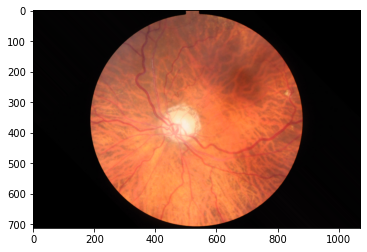

In [16]:
x_batch, y_batch = train_less_gen.next()
plt.imshow(x_batch[0])

In [17]:
y_batch[0]

array([0, 0, 0, 1, 0, 0, 1, 0, 0])

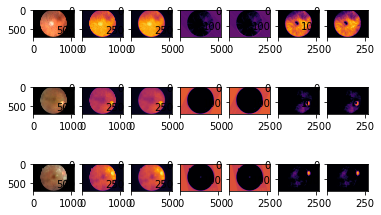

In [22]:
FILTER_NUMBER = 2
layer_outputs = [layer.output for layer in cnn_less.layers]
activation_model = tf.keras.models.Model(inputs=cnn_less.input,outputs=layer_outputs)

f, axarr = plt.subplots(3,7)

axarr[0,0].imshow(x_batch[0])
axarr[0,0].grid(False)
axarr[1,0].imshow(x_batch[1])
axarr[1,0].grid(False)
axarr[2,0].imshow(x_batch[2])
axarr[2,0].grid(False)

for i, x in enumerate([0, 2, 3, 5, 6, 7]):
  f1 = activation_model.predict(x_batch[0].reshape(1, target_size[0], target_size[1], 3))[x]
  axarr[0,i+1].imshow(f1[0, : , :, FILTER_NUMBER], cmap='inferno')
  axarr[0,i+1].grid(False)
  f2 = activation_model.predict(x_batch[1].reshape(1, target_size[0], target_size[1], 3))[x]
  axarr[1,i+1].imshow(f2[0, : , :, FILTER_NUMBER], cmap='inferno')
  axarr[1,i+1].grid(False)
  f3 = activation_model.predict(x_batch[2].reshape(1, target_size[0], target_size[1], 3))[x]
  axarr[2,i+1].imshow(f3[0, : , :, FILTER_NUMBER], cmap='inferno')
  axarr[2,i+1].grid(False)